# Data Preparation

Fetching the data

To load the data from remote, you have two options,

   i) to build a database, insert data, and using some api (say MySQL connector) to fetch data.
  
  ii) to use some open/paid and well-defined api to get structured or semi-structured data.

The first one is more practical, but the data source cannot be validated. We can randomly generate some data and insert it into database, then fetching it to local. But in this way, it is kind of similar as directly generating data locally.

There are some websites that provide good APIs with history data e.g. conindesk. Therefore, I am choosing second option.

In [1]:
import requests

def get_response(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

In [2]:
from datetime import datetime

def get_datetime():
    return datetime.now().strftime('%Y-%m-%d')


In [14]:
from collections import OrderedDict

def get_historical_data(start, end):
        if not end:
            end = start
        url = (
            'https://api.coindesk.com/v1/bpi/historical/close.json'
            '?start={}&end={}'.format(
                start, end
            )
        )
        return get_response(url)

def get_historical_data_as_dict(start, end):
    if not end:
        end = get_datetime()
    data = get_historical_data(start, end)
    prices = data['bpi']
    # prices = {k: Decimal(str(v)) for (k,v) in prices.items()}
    prices = OrderedDict(sorted(prices.items(), key=lambda t: t[0]))
    return prices


In [17]:
import csv

ts = get_historical_data_as_dict('2018-01-01', end = None)

with open('Bitcoin2018.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in ts.items():
        writer.writerow([key, value])

Now, we have data. Lets further divide this data into Training and Testing

In [18]:
import pandas as pd

startdate = '2018-01-01'
enddate = '2018-10-10'

rng = pd.date_range(start=startdate, end=enddate, freq='D')

In [19]:
ts = get_historical_data_as_dict(startdate, enddate)

In [22]:
import numpy as np

TS = np.array([v for (k, v) in ts.items()])

In [24]:
num_periods = 20
# forecast horizon, one period into the future
f_horizon = 1

x_data = TS[:(len(TS) - (len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

In [25]:
x_data.shape

(280,)

In [26]:
x_batches.shape

(14, 20, 1)

In [27]:
y_data = TS[1:(len(TS) - (len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 20, 1)

print(y_data.shape)
print(y_batches.shape)

(280,)
(14, 20, 1)


In [30]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX, testY

In [31]:
X_test, Y_test = test_data(TS, f_horizon, num_periods)

In [36]:
X_test.shape

(1, 20, 1)

We parsed the data to 20-day blocks. I have also chosen last 20 day block for testing.

# Data Processing

In [67]:
import tensorflow as tf
import psutil

In [69]:
# didn't have any previous graph objects running, but this would reset the graphs.
tf.reset_default_graph()

In [70]:
# num_periods = 20 --> number of periods per vector we are using to predict one period ahead

# number of vectors submitted
inputs = 1

# number of neurons we will recursively work through, can be changed to improve accuracy
hidden = 500

# number of ouput vectors
output = 1

In [71]:
# create variable objects

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)

rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) # choose dynamic over static

# small learning rate so we don't overshoot the minimum
learning_rate = 0.001

# change the form into a tensor
stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])

# specify the type of layer (dense)
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)

# shape of results
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

# define the cost function which evaluates the quality of our model
loss = tf.reduce_sum(tf.square(outputs - y))

# gradient descent method
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 

# train the result of the application of the cost_function
training_op = optimizer.minimize(loss)

# initialize all the variables
init = tf.global_variables_initializer()

# number of iterations or training cycles, includes both the FeedFoward and Backpropogation
epochs = 1000 

In [72]:
# sample usage of cpu and memory
# psutil.cpu_percent()
# psutil.virtual_memory().used

cpus = np.array([])
mems = np.array([])
mses = np.array([])

cpuho = tf.placeholder(tf.float32)
memho = tf.placeholder(tf.float32)
lossho = tf.placeholder(tf.float32)

tf.summary.scalar('loss', lossho)
tf.summary.scalar('cpu-usage', cpuho)
tf.summary.scalar('memory-usage', memho)
merged = tf.summary.merge_all()

with tf.Session() as sess:
    train_writer = tf.summary.FileWriter('./', sess.graph)
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})

        cpu = psutil.cpu_percent()
        mem = psutil.virtual_memory().used
        mse = loss.eval(feed_dict={X: x_batches, y: y_batches})

        cpus = np.append(cpus, cpu)
        mems = np.append(mems, mem)
        mses = np.append(mses, mse)
        sumary = sess.run(merged, feed_dict={
                          lossho: mse, cpuho: cpu, memho: mem})
        train_writer.add_summary(sumary, ep)

        if ep % 100 == 0:
            # mean square error
            print(ep + 100, "\tMSE:", mse)

    y_pred = sess.run(outputs, feed_dict={X: X_test})
    # print(y_pred)

epochs = np.arange(epochs)

100 	MSE: 11012096000.0
200 	MSE: 130758824.0
300 	MSE: 38671570.0
400 	MSE: 30287080.0
500 	MSE: 28153196.0
600 	MSE: 22199132.0
700 	MSE: 20558618.0
800 	MSE: 18626352.0
900 	MSE: 16265652.0
1000 	MSE: 14919490.0


# Result Storage

In [116]:
# MongoDB
from pymongo import MongoClient

In [122]:
# database client
client = MongoClient()

# will saved processed data into this database collection
collection = client.bitcoin_predict.parameters

# remove old parameters
collection.remove()

/home/chandrahas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.
  


{'n': 6, 'ok': 1.0}

In [124]:
collection.remove()

/home/chandrahas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.
  """Entry point for launching an IPython kernel.


{'n': 0, 'ok': 1.0}

In [125]:
collection.insert_many([
    {
        'name': 'Y_test',
        'val': Y_test.tolist()
    },
    {
        'name': 'y_pred',
        'val': y_pred.tolist()
    },
    {
        'name': 'epochs',
        'val': epochs.tolist()
    },
    {
        'name': 'mses',
        'val': mses.tolist()
    },
    {
        'name': 'cpus',
        'val': cpus.tolist()
    },
    {
        'name': 'mems',
        'val': mems.tolist()
    },
])

print("data saved")

data saved


# Retrieval of data

In [126]:
# Fetch data
Y_test = np.array(collection.find({'name': 'Y_test'})[0]['val'])
y_pred = np.array(collection.find({'name': 'y_pred'})[0]['val'])
epochs = np.array(collection.find({'name': 'epochs'})[0]['val'])
mses = np.array(collection.find({'name': 'mses'})[0]['val'])
cpus = np.array(collection.find({'name': 'cpus'})[0]['val'])
mems = np.array(collection.find({'name': 'mems'})[0]['val'])

In [127]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


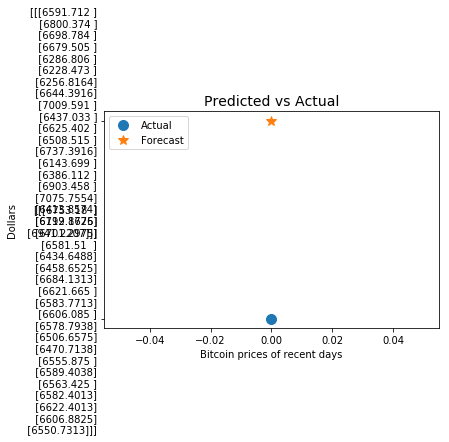

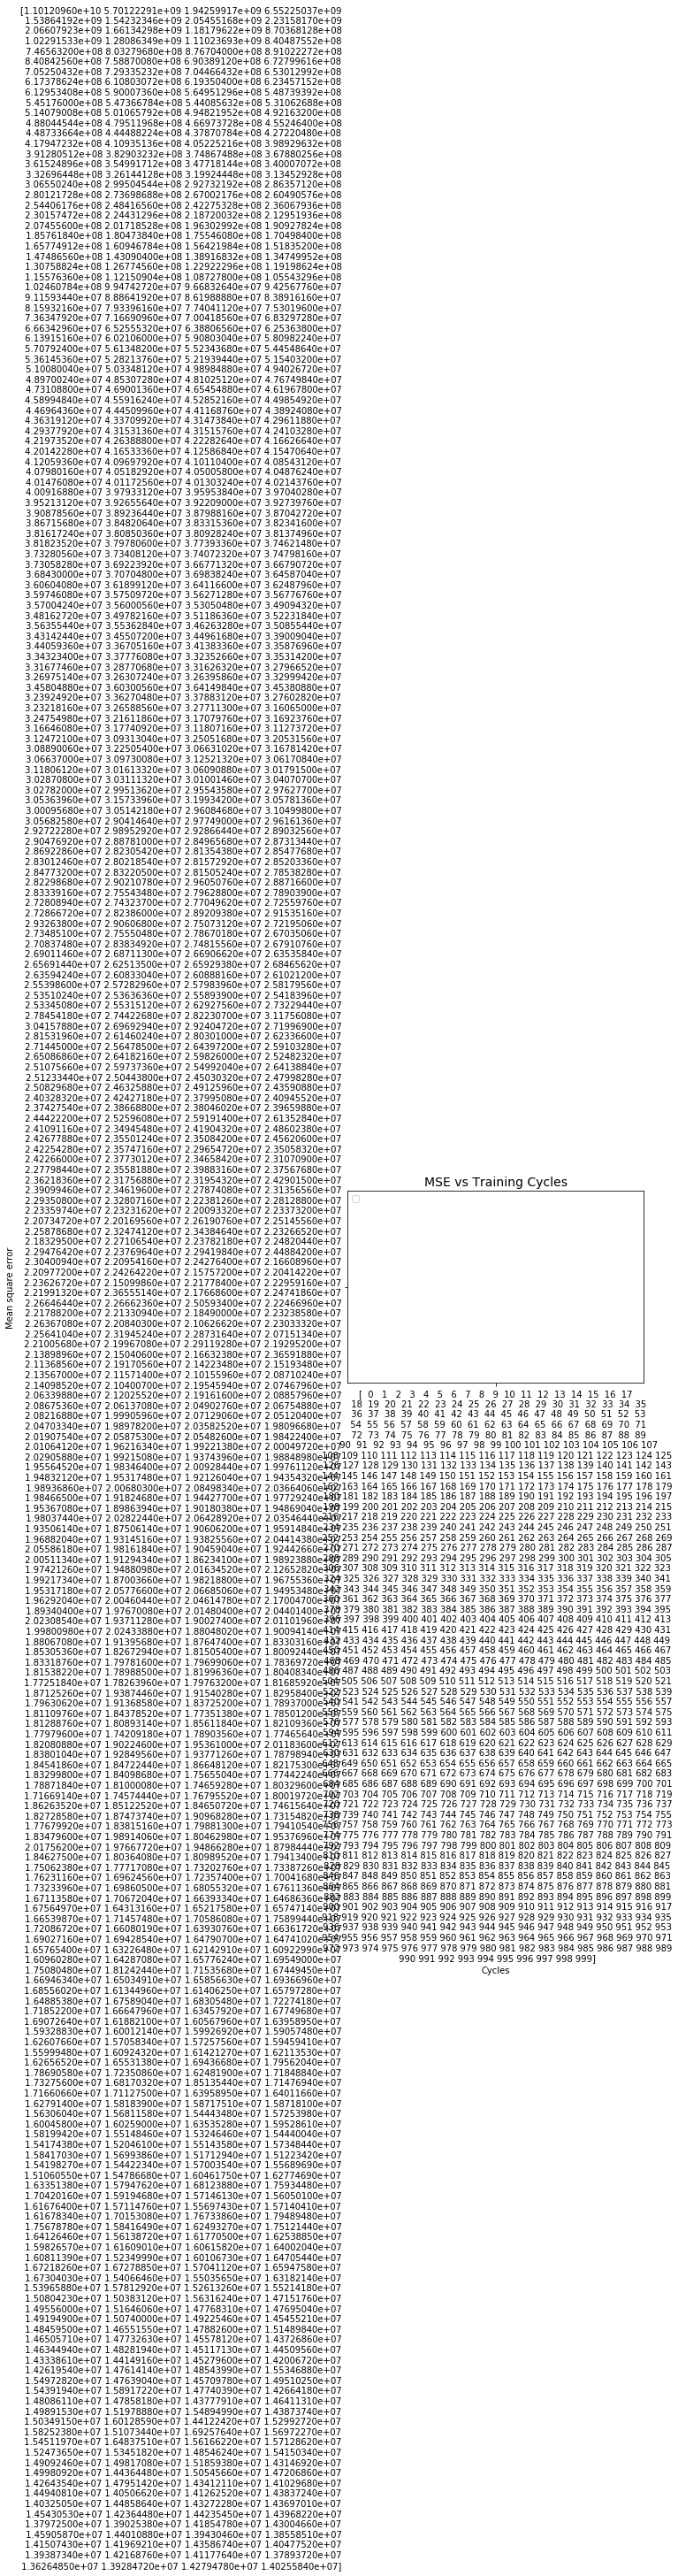

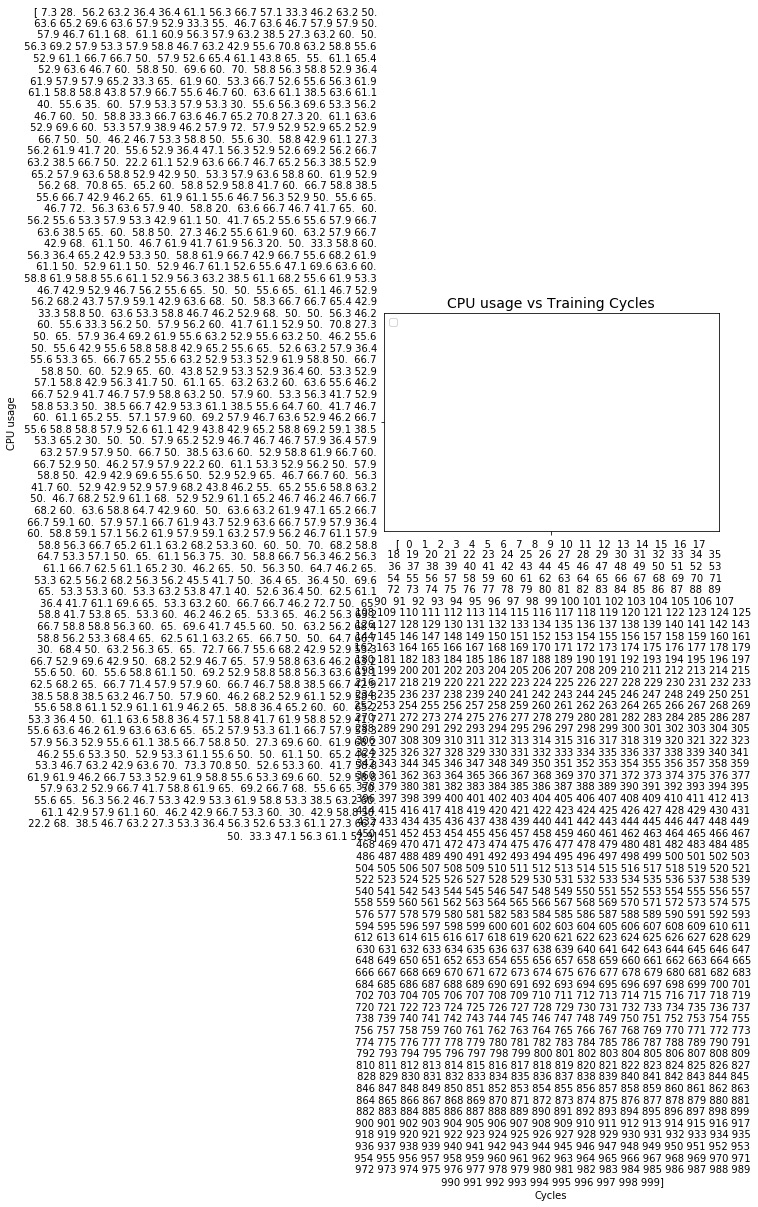

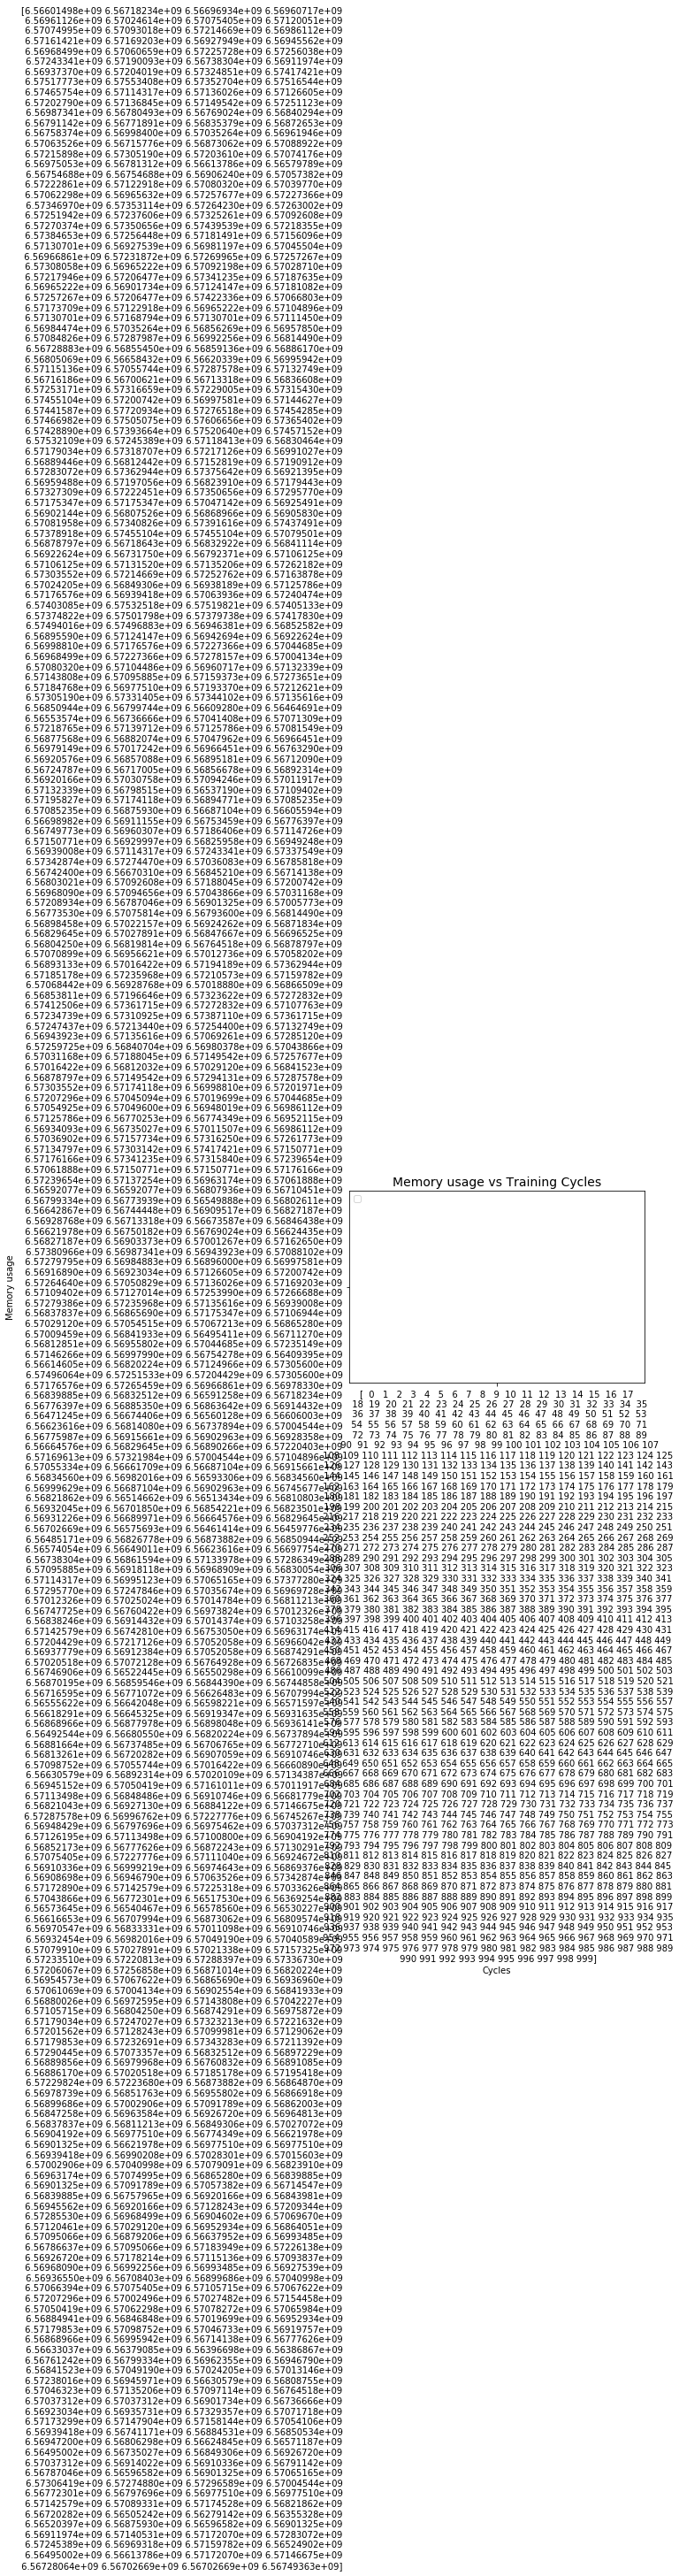

In [128]:
# Result
plt.figure()
plt.title("Predicted vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "o", markersize=10, label="Actual")
# plt.plot(pd.Series(np.ravel(Y_test)), "w.", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "*", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Bitcoin prices of recent days")
plt.ylabel("Dollars")
#plt.axis([-1, 1, 6000, 7000])
plt.savefig("img/result.svg")

# Loss function
plt.figure()
plt.title("MSE vs Training Cycles", fontsize=14)
plt.plot(epochs, mses)
plt.legend(loc="upper left")
plt.xlabel("Cycles")
plt.ylabel("Mean square error")
plt.savefig("img/loss.svg")

# CPU usage
plt.figure()
plt.title("CPU usage vs Training Cycles", fontsize=14)
plt.plot(epochs, cpus)
plt.legend(loc="upper left")
plt.xlabel("Cycles")
plt.ylabel("CPU usage")
plt.savefig("img/cpu.svg")

# Memory usage
plt.figure()
plt.title("Memory usage vs Training Cycles", fontsize=14)
plt.plot(epochs, mems)
plt.legend(loc="upper left")
plt.xlabel("Cycles")
plt.ylabel("Memory usage")
plt.savefig("img/mem.svg")

plt.show()